# Inverse Solve

We solve the inverse problem of identifying the underlying, spatially-varying thermal conductivity $h(x,y)$ given the surface temperature $T(x,y)$ and a constant heat source $q(x,y)=1$ within a unit square domain $[0,1]\times[0,1]$.

The system is described by the steady-state Poisson heat equation in two dimensions (2D) and subjected to the following mixed boundary conditions:
 - $T=300K$ at the bottom.
 - Insulated walls, i.e. $\frac{\partial T}{\partial \hat{n}}$ ($\hat{n}$ being the surface unit vector), on the other three sides.

To find $h$, we will minimize the following cost function J:

$J=\frac{1}{2}\left[\frac{\left(T-T_{\rm obs}\right)^2}{\sigma^2}+\alpha|\nabla^2 h|\right]$,

using the conjugate-gradient-descend method. Since the forward solver does not provide the gradient, we will solve for the gradient using the adjoint method.

In [1]:
import os
import h5py as h5
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

from forward_solver import SteadyHeat2DForwardSolver as ForwardSolver
from adjoint_solver import SteadyHeat2DAdjointSolver as AdjoinSolver
from tao_solver import SteadyHeat2DTAOSolver

## Load saved output from disk

In [2]:
test_dir='../test_data/'
test_outfile_name='blackbox_output'
test_outfile_format='.xdmf'

def list_h5(name, obj):
    """
    HDF5 IO helper
    """
    if isinstance(obj, h5.Dataset):
        print(f"{name}    Dataset, shape={obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{name}    Group")

test_outfile_format='.h5'
with h5.File(os.path.join(test_dir,test_outfile_name+test_outfile_format), 'r') as f:
    f.visititems(list_h5)
    T_noiseless = f['Function/Temperature/0'][()]
    T_noisy = f['Function/ObservedTemperature/0'][()]

Function    Group
Function/HeatSource    Group
Function/HeatSource/0    Dataset, shape=(16641, 1), dtype=float64
Function/ObservedTemperature    Group
Function/ObservedTemperature/0    Dataset, shape=(16641, 1), dtype=float64
Function/Temperature    Group
Function/Temperature/0    Dataset, shape=(16641, 1), dtype=float64
Function/ThermalConductivity    Group
Function/ThermalConductivity/0    Dataset, shape=(16641, 1), dtype=float64
Mesh    Group
Mesh/mesh    Group
Mesh/mesh/geometry    Dataset, shape=(16641, 2), dtype=float64
Mesh/mesh/topology    Dataset, shape=(16384, 4), dtype=int64


### Forward solver

#### Define domain

In [3]:
nmesh=128
mesh_type='quadrilateral'

#### Define heat source

In [4]:
q=1.0 # constant heat source

#### Define boundary condition

In [5]:
T_bottom=300. # in Kelvin, Dirichlet boundary condition on the bottom

#### Define solver settings

In [6]:
petsc_options = {
     'ksp_type': 'cg',
     'pc_type': 'hypre',
     'ksp_rtol': 1e-12,
}

#### Define intial guess for the "unknown" thermal conductivity

In [7]:
h_init = 4.*np.ones((nmesh,nmesh), dtype=float)
idx=np.arange(nmesh)
xx,yy=np.meshgrid(idx,idx,indexing='ij')
hmesh_init=np.column_stack([xx.ravel(),yy.ravel(),h_init.ravel()])

#### Define forward solver

In [8]:
fwd_solver=ForwardSolver(nmesh=nmesh, mesh_type=mesh_type, \
                                          h=hmesh_init, q=q,\
                                          DBC_value=T_bottom,
                                          petsc_opts=petsc_options)
fwd_solver.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 1)

#### Define adjoint solver

In [9]:
## Defaul parameter values for the adjoint solver
sigma = 1e-3 ## noise std.
alpha = 1e-2 ## amplitude of regularization term
adj_solver = AdjointSolver(fwd_solver, T_noisy.squeeze(axis=1), sigma=sigma, alpha=alpha, DBC_value=T_bottom, petsc_opts=petsc_options)
adj_solver.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 3)

In [10]:
def default_monitor(tao):
    it  = tao.getIterationNumber()
    obj = tao.getObjectiveValue()
    print(f"[TAO] iter={it:3d};  J={obj:.6e}.")

solvers = ['bncg','blmvm']
ls_algorithm=['more-thuente','armijo']
gatol=1e-5
grtol=1e-5
gttol=1e-6
verbose=1
tao_solver = SteadyHeat2DTAOSolver(fwd_solver, adj_solver, tao_type=solvers[1], ls_algorithm=ls_algorithm[1],
                                                 use_logh=True, h_min=0.1, h_max=10.,
                                                 gatol=gatol, grtol=grtol, gttol=gttol, mit=1000,
                                                 monitor=default_monitor, verbose=1)

Optimize in m=log(h).
Initial guess for m=log(h) = [1.38629436 1.38629436 1.38629436 ... 1.38629436 1.38629436 1.38629436]
Set bounds on m=log(h).
Line search algorithm: armijo


In [11]:
sol=tao_solver.solve()
print("Solution h(x,y)=",sol)

[TAO] iter=  0;  J=4.388286e+02.
[TAO] iter=  1;  J=3.298393e+02.
[TAO] iter=  2;  J=1.480864e+02.
[TAO] iter=  3;  J=1.185632e+02.
[TAO] iter=  4;  J=1.034114e+02.
[TAO] iter=  5;  J=8.325417e+01.
[TAO] iter=  6;  J=3.560621e+01.
[TAO] iter=  7;  J=3.225774e+01.
[TAO] iter=  8;  J=2.506265e+01.
[TAO] iter=  9;  J=2.241735e+01.
[TAO] iter= 10;  J=1.689874e+01.
[TAO] iter= 11;  J=1.234174e+01.
[TAO] iter= 12;  J=9.132965e+00.
[TAO] iter= 13;  J=8.355527e+00.
[TAO] iter= 14;  J=7.560006e+00.
[TAO] iter= 15;  J=6.884866e+00.
[TAO] iter= 16;  J=6.212966e+00.
[TAO] iter= 17;  J=5.486050e+00.
[TAO] iter= 18;  J=4.446401e+00.
[TAO] iter= 19;  J=3.785188e+00.
[TAO] iter= 20;  J=3.255475e+00.
[TAO] iter= 21;  J=2.984031e+00.
[TAO] iter= 22;  J=2.771867e+00.
[TAO] iter= 23;  J=2.575457e+00.
[TAO] iter= 24;  J=2.385487e+00.
[TAO] iter= 25;  J=2.194169e+00.
[TAO] iter= 26;  J=2.006220e+00.
[TAO] iter= 27;  J=1.830961e+00.
[TAO] iter= 28;  J=1.688556e+00.
[TAO] iter= 29;  J=1.578112e+00.
[TAO] iter

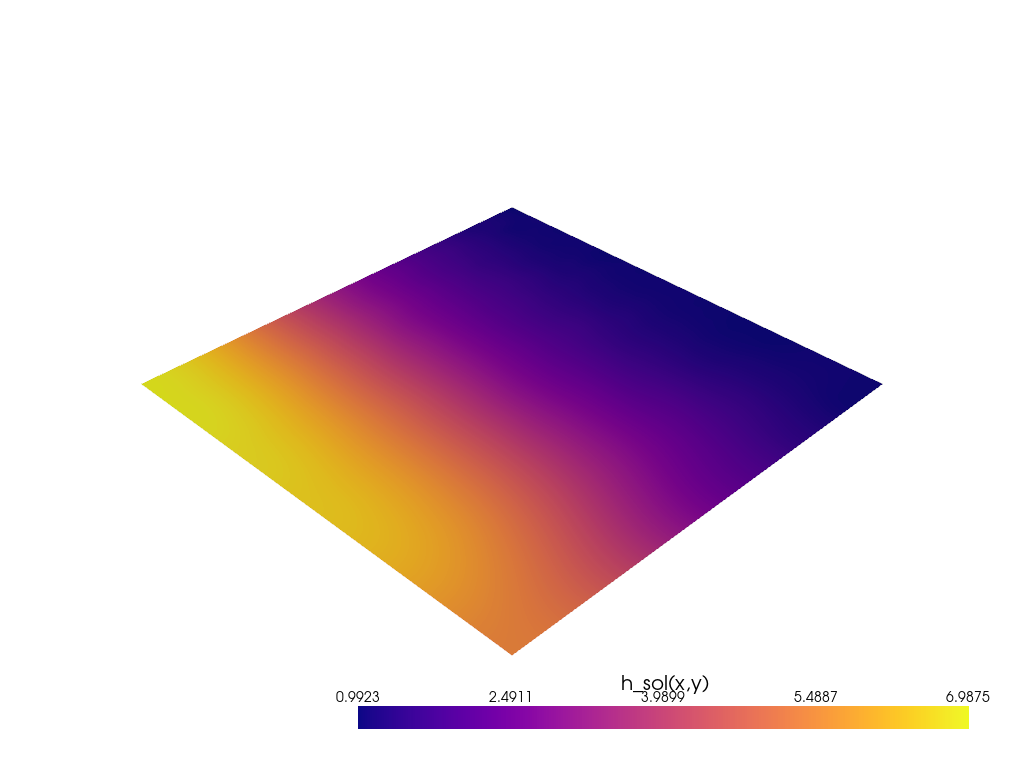

UnstructuredGrid (0x31b76b040)
  N Cells:    16384
  N Points:   16641
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

In [12]:
from plotting_utils import plot_scalar_mesh
plot_scalar_mesh(fwd_solver.V.mesh,sol,'h_sol(x,y)',cmap='plasma',user_scalar_bar={"fmt": "%.4f"})

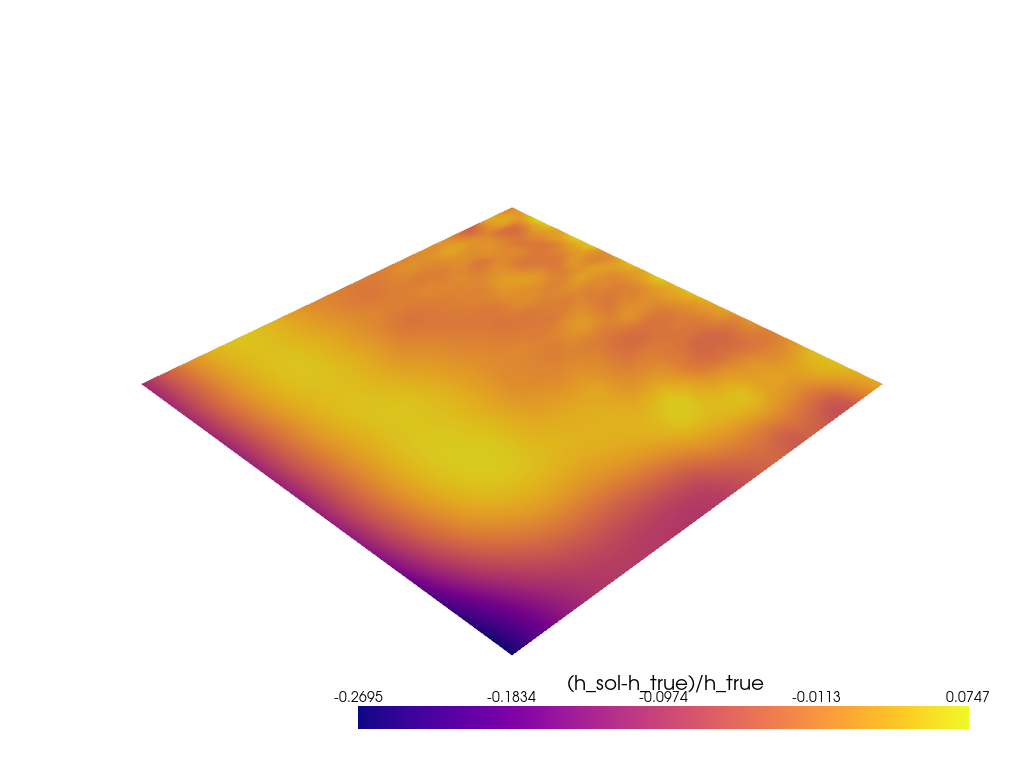

UnstructuredGrid (0x31f3dfca0)
  N Cells:    16384
  N Points:   16641
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

In [13]:
def h_func(x):
    return 1.0 + 6.0*x[0]**2 + x[0]/(1.0 + 2.0*x[1]**2)
blackbox_solver=ForwardSolver(nmesh=nmesh, mesh_type=mesh_type, \
                                          h=h_func, q=q,\
                                          DBC_value=T_bottom,
                                          petsc_opts=petsc_options)

rel_diff=(sol-blackbox_solver.h.function.x.array)/blackbox_solver.h.function.x.array
plot_scalar_mesh(fwd_solver.V.mesh,rel_diff,'(h_sol-h_true)/h_true',cmap='plasma',user_scalar_bar={"fmt": "%.4f"})